In [1]:
!pip install datasets


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Part 1

In [2]:
# Question 1(a): What is the size of the vocabulary formed from your training data?

from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']

# Initialize an empty set to store unique words
vocabulary = set()

# Tokenize each review in the training dataset and update the vocabulary set
for text in train_dataset['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Print the size of the vocabulary
print("The size of the vocabulary is:", len(vocabulary))


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
Using the latest cached version of the dataset since rotten_tomatoes couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Hendy\.cache\huggingface\datasets\rotten_tomatoes\default\0.0.0\aa13bc287fa6fcab6daf52f0dfb9994269ffea28 (last modified on Wed Oct 23 17:03:50 2024).


The size of the vocabulary is: 18029


In [3]:
# Question 1(b): How many OOV words exist in your training data?

import numpy as np

# Load the GloVe embeddings (make sure to download 'glove.6B.100d.txt' and place it in the working directory)
glove_vocab = set()
glove_embeddings = {}
embedding_dim = 100
with open('glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        glove_vocab.add(word)
        glove_embeddings[word] = np.asarray(values[1:], dtype='float32')

# Identify OOV words
oov_words = vocabulary - glove_vocab

# Print the number of OOV words
print("Number of OOV words in the training data:", len(oov_words))

Number of OOV words in the training data: 1865


In [4]:
# Question 1(c): Handle OOV words using ngram and backoff and interpolation

from collections import defaultdict

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

# Initialize the embedding matrix for known words
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]

        
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]

        
# Create n-grams from training data
def create_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for entry in texts:  # Adjusted to iterate over each entry (dictionary)
        text = entry['text']  # Access the text with the appropriate key
        tokens = word_tokenize(text.lower())
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Create n-grams
        for ngram in ngrams:
            ngram_counts[' '.join(ngram)] += 1
    return ngram_counts

# Create bigrams and trigrams
bigram_counts = create_ngrams(train_dataset, 2)  # Use train_raw directly
trigram_counts = create_ngrams(train_dataset, 3)  # Use train_raw directly

# Backoff and interpolation parameters
lambda1 = 0.8  # weight for unigrams
lambda2 = 0.15  # weight for bigrams
lambda3 = 0.05  # weight for trigrams

# Define a function for backoff and interpolation handling OOV words
def get_ngram_embedding(word, embedding_matrix, word2idx, bigram_counts, trigram_counts):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # Initialize embeddings for interpolation
        unigram_embedding = np.zeros(embedding_matrix.shape[1])
        bigram_embedding = np.zeros(embedding_matrix.shape[1])
        trigram_embedding = np.zeros(embedding_matrix.shape[1])
        
        # Check trigram context
        trigram_context = [ngram for ngram in trigram_counts if word in ngram.split()]
        if trigram_context:
            context_ngram = trigram_context[0].split()
            trigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Check bigram context
        bigram_context = [ngram for ngram in bigram_counts if word in ngram.split()]
        if bigram_context:
            context_ngram = bigram_context[0].split()
            bigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Calculate unigram embedding (mean of known embeddings, if available)
        known_words = [w for w in word2idx if w in vocabulary]
        if known_words:
            unigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in known_words if word2idx[w] < len(embedding_matrix)], axis=0)

        # Apply interpolation
        final_embedding = (lambda1 * unigram_embedding) + (lambda2 * bigram_embedding) + (lambda3 * trigram_embedding)
        return final_embedding

# Handle OOV words using n-gram embeddings
for oov_word in oov_words:
    if oov_word in word2idx:  # Ensure the OOV word exists in word2idx
        idx = word2idx[oov_word]
        embedding_matrix[idx] = get_ngram_embedding(oov_word, embedding_matrix, word2idx, bigram_counts, trigram_counts)

# Now, the embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (18029, 100)


## Part 2

In [5]:
# Train the model
train_losses, val_accuracies = [], []

In [6]:
# Import necessary libraries
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

# Download the punkt tokenizer
nltk.download('punkt')

# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Function to create n-grams from training data
def create_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for entry in texts:  # Adjusted to iterate over each entry (dictionary)
        text = entry['text']  # Access the text with the appropriate key
        tokens = word_tokenize(text.lower())
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Create n-grams
        for ngram in ngrams:
            ngram_counts[' '.join(ngram)] += 1
    return ngram_counts

# Create bigrams and trigrams
bigram_counts = create_ngrams(train_raw, 2)  # Use train_raw directly
trigram_counts = create_ngrams(train_raw, 3)  # Use train_raw directly

# Calculate total counts for smoothing
total_bigrams = sum(bigram_counts.values())
total_trigrams = sum(trigram_counts.values())

# Backoff and interpolation parameters
lambda1 = 0.8  # weight for unigrams
lambda2 = 0.15  # weight for bigrams
lambda3 = 0.05  # weight for trigrams

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = 'glove.6B.100d.txt'  # Update the path if necessary
glove_vocab = set()
glove_embeddings = {}

# Load GloVe embeddings into a dictionary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_vocab.add(word)
            glove_embeddings[word] = vector

# Function to handle OOV words using backoff and interpolation
def get_embedding(word):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # OOV word handling via bigram and trigram context
        tokens = word_tokenize(word.lower())
        bigram_context = [' '.join(tokens[i:i + 2]) for i in range(len(tokens) - 1)]
        trigram_context = [' '.join(tokens[i:i + 3]) for i in range(len(tokens) - 2)]

        # Check trigram context
        if any(trigram in trigram_counts for trigram in trigram_context):
            interpolated_embedding = np.mean(
                [glove_embeddings[word] for word in trigram_context if word in glove_vocab], axis=0
            )
            return (1 - (lambda1 + lambda2 + lambda3)) * interpolated_embedding

        # Check bigram context
        elif any(bigram in bigram_counts for bigram in bigram_context):
            interpolated_embedding = np.mean(
                [glove_embeddings[word] for word in bigram_context if word in glove_vocab], axis=0
            )
            return lambda2 * interpolated_embedding

        # Default to zero vector for complete OOV
        return np.zeros(embedding_dim)

# Fill the embedding matrix with GloVe embeddings and handle OOV words
for word in vocabulary:
    if word in glove_vocab:
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        # Use backoff and interpolation for OOV words
        embedding_matrix[word2idx[word]] = get_embedding(word)

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

# Now embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)

# Define a function to convert sentences to indices
def sentence_to_indices(sentence, word2idx):
    tokens = word_tokenize(sentence.lower())
    indices = []
    for token in tokens:
        if token in word2idx:
            indices.append(word2idx[token])
        else:
            indices.append(word2idx['<unk>'])  # Map unknown words to '<unk>'
    return indices

# Define the custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, word2idx):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = sentence_to_indices(text, self.word2idx)
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float).unsqueeze(0)  # Add this unsqueeze(0)

# Create datasets for training, validation, and testing
train_dataset = SentimentDataset(train_raw['text'], train_raw['label'], word2idx)
val_dataset = SentimentDataset(validation_raw['text'], validation_raw['label'], word2idx)
test_dataset = SentimentDataset(test_raw['text'], test_raw['label'], word2idx)

# Define the collate_fn function for padding within batches
def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.float)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=word2idx['<pad>'])
    return sequences_padded, labels

# Create DataLoaders for training, validation, and testing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Define the RNN model using pre-trained embeddings
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNN, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    # In the SentimentRNN class
    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)
        lstm_out = torch.cat((h_n[-2], h_n[-1]), dim=1)  # (batch_size, 512)
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        out = self.fc1(lstm_out)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)  # Apply sigmoid activation to the output
        return out.squeeze(1)  # Return output without an extra dimension

# Initialize the model, loss function, and optimizer
model = SentimentRNN(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)


[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
Using the latest cached version of the dataset since rotten_tomatoes couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\Hendy\.cache\huggingface\datasets\rotten_tomatoes\default\0.0.0\aa13bc287fa6fcab6daf52f0dfb9994269ffea28 (last modified on Wed Oct 23 17:03:50 2024).


Embedding matrix shape: (18031, 100)


C:\Users\Hendy\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [7]:

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience
best_val_accuracy = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # Learning rate scheduling
    scheduler.step(val_accuracy)
    
    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break
            


Epoch [1/30], Loss: 0.6242, Validation Accuracy: 0.7280
Epoch [2/30], Loss: 0.5419, Validation Accuracy: 0.7167
Epoch [3/30], Loss: 0.5000, Validation Accuracy: 0.7111
Epoch [4/30], Loss: 0.4910, Validation Accuracy: 0.7505
Epoch [5/30], Loss: 0.4706, Validation Accuracy: 0.7561
Epoch [6/30], Loss: 0.4432, Validation Accuracy: 0.7692
Epoch [7/30], Loss: 0.4200, Validation Accuracy: 0.7739
Epoch [8/30], Loss: 0.3948, Validation Accuracy: 0.7467
Epoch [9/30], Loss: 0.3728, Validation Accuracy: 0.7617
Epoch [10/30], Loss: 0.3511, Validation Accuracy: 0.7580
Epoch [11/30], Loss: 0.2931, Validation Accuracy: 0.7749
Epoch [12/30], Loss: 0.2613, Validation Accuracy: 0.7674
Epoch [13/30], Loss: 0.2298, Validation Accuracy: 0.7664
Epoch [14/30], Loss: 0.2099, Validation Accuracy: 0.7505
Epoch [15/30], Loss: 0.1636, Validation Accuracy: 0.7655
Epoch [16/30], Loss: 0.1390, Validation Accuracy: 0.7589
Early stopping!


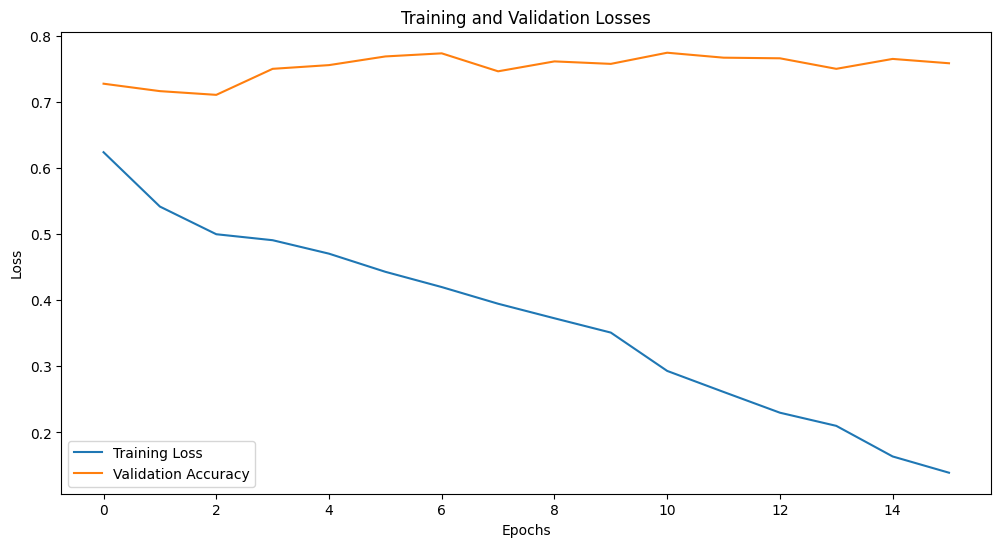

In [8]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

train_losses, val_accuracies = [], []

In [9]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = model(sequences)
        predicted = (outputs >= 0.5).long()
        correct += (predicted == labels.long()).sum().item()
        total += labels.size(0)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7767


In [10]:
#3.1

In [11]:
class SentimentRNN_UpdateEmbeddings(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNN_UpdateEmbeddings, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True  # Update the embeddings during training
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [12]:
# Instantiate the model
model = SentimentRNN_UpdateEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience
best_val_accuracy = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduling
    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_update_embeddings.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model_update_embeddings.pt'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = model(sequences)
        predicted = (outputs >= 0.5).long()
        correct += (predicted == labels.long()).sum().item()
        total += labels.size(0)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

C:\Users\Hendy\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/30], Loss: 0.6365, Validation Accuracy: 0.7017
Epoch [2/30], Loss: 0.4857, Validation Accuracy: 0.7223
Epoch [3/30], Loss: 0.3611, Validation Accuracy: 0.7758
Epoch [4/30], Loss: 0.2331, Validation Accuracy: 0.7805
Epoch [5/30], Loss: 0.1407, Validation Accuracy: 0.7711
Epoch [6/30], Loss: 0.0788, Validation Accuracy: 0.7580
Epoch [7/30], Loss: 0.0424, Validation Accuracy: 0.7477
Epoch [8/30], Loss: 0.0226, Validation Accuracy: 0.7570
Epoch [9/30], Loss: 0.0119, Validation Accuracy: 0.7533
Early stopping!
Test Accuracy: 0.8058


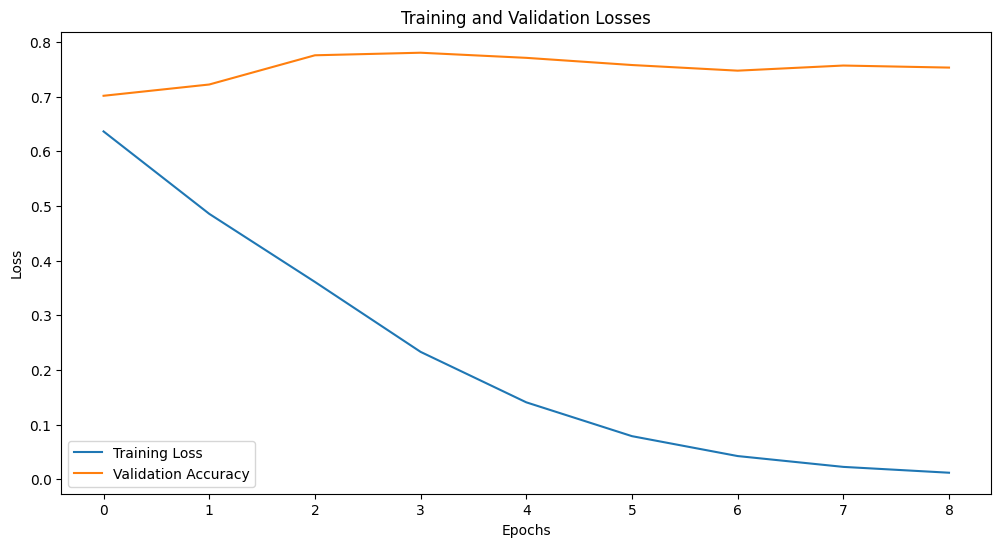

In [13]:
# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


train_losses, val_accuracies = [], []

In [14]:
#3.2

In [15]:
# Load the GloVe embeddings
glove_vocab = set()
glove_embeddings = {}

# Load GloVe embeddings into a dictionary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            # Normalize the loaded vectors to have unit norm
            vector /= np.linalg.norm(vector)
            glove_embeddings[word] = vector  # Use 'word' instead of 'glove_word'
            glove_vocab.add(word)

# Function to handle OOV words using backoff and interpolation
def get_embedding(word):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # OOV word handling via bigram and trigram context
        tokens = word_tokenize(word.lower())
        bigram_context = [' '.join(tokens[i:i + 2]) for i in range(len(tokens) - 1)]
        trigram_context = [' '.join(tokens[i:i + 3]) for i in range(len(tokens) - 2)]

        # Check trigram context
        if any(trigram in trigram_counts for trigram in trigram_context):
            interpolated_embedding = np.mean(
                [glove_embeddings[trigram] for trigram in trigram_context if trigram in glove_vocab], axis=0
            )
            return (1 - (lambda1 + lambda2 + lambda3)) * interpolated_embedding

        # Check bigram context
        elif any(bigram in bigram_counts for bigram in bigram_context):
            interpolated_embedding = np.mean(
                [glove_embeddings[bigram] for bigram in bigram_context if bigram in glove_vocab], axis=0
            )
            return lambda2 * interpolated_embedding

        # Default to zero vector for complete OOV
        return np.zeros(embedding_dim)

# Fill the embedding matrix with GloVe embeddings and handle OOV words
for word in vocabulary:
    if word in glove_vocab:
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        # Use backoff and interpolation for OOV words
        embedding_matrix[word2idx[word]] = get_embedding(word)

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

# Now embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)

# Load GloVe embeddings into the embedding matrix where possible
for idx, word in enumerate(vocabulary):
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]


Embedding matrix shape: (18031, 100)


In [16]:
class SentimentRNN_OOV(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNN_OOV, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [17]:

# Instantiate the model
model = SentimentRNN_OOV(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience
best_val_accuracy = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduling
    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_oov.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break


Epoch [1/30], Loss: 0.6351, Validation Accuracy: 0.7448
Epoch [2/30], Loss: 0.4283, Validation Accuracy: 0.7514
Epoch [3/30], Loss: 0.2320, Validation Accuracy: 0.7420
Epoch [4/30], Loss: 0.1156, Validation Accuracy: 0.7514
Epoch [5/30], Loss: 0.0736, Validation Accuracy: 0.7495
Epoch [6/30], Loss: 0.0319, Validation Accuracy: 0.7430
Epoch [7/30], Loss: 0.0161, Validation Accuracy: 0.7561
Epoch [8/30], Loss: 0.0095, Validation Accuracy: 0.7430
Epoch [9/30], Loss: 0.0055, Validation Accuracy: 0.7392
Epoch [10/30], Loss: 0.0051, Validation Accuracy: 0.7430
Epoch [11/30], Loss: 0.0014, Validation Accuracy: 0.7439
Epoch [12/30], Loss: 0.0005, Validation Accuracy: 0.7364
Early stopping!


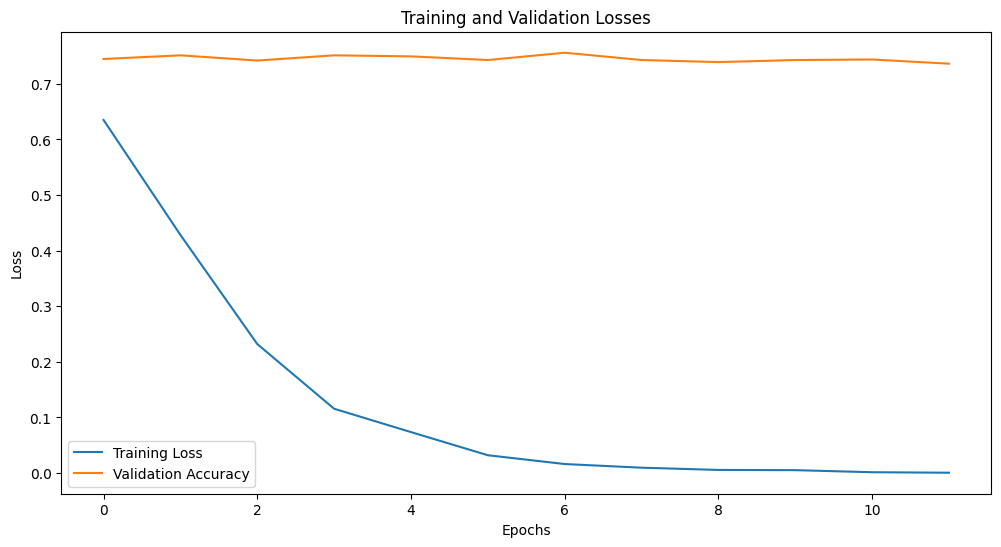

In [18]:
# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

train_losses, val_accuracies = [], []

In [19]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model_oov.pt'))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = model(sequences)
        predicted = (outputs >= 0.5).long()
        correct += (predicted == labels.long()).sum().item()
        total += labels.size(0)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.7692


In [20]:
# biLSTM Model
class SentimentBiLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentBiLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [21]:
# biLSTM Model
class SentimentBiLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentBiLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()


# biGRU Model
class SentimentBiGRU(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentBiGRU, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.gru = nn.GRU(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        gru_out, h_n = self.gru(embeds)

        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()




In [22]:
# Instantiate the models
bilstm_model = SentimentBiLSTM(embedding_matrix)
bigru_model = SentimentBiGRU(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bilstm_model.to(device)
bigru_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
bilstm_optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=0.001, weight_decay=1e-5)
bigru_optimizer = torch.optim.Adam(bigru_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(bilstm_optimizer, 'max', patience=2, factor=0.5, verbose=True)

In [23]:
# Training loop with validation and early stopping for biLSTM
num_epochs = 30
patience = 5  # Early stopping patience
best_val_accuracy = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    bilstm_model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        bilstm_optimizer.zero_grad()
        outputs = bilstm_model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bilstm_model.parameters(), max_norm=1)  # Gradient clipping
        bilstm_optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    bilstm_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = bilstm_model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduling
    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(bilstm_model.state_dict(), 'best_bilstm_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# Load the best model and evaluate on the test set for biLSTM
bilstm_model.load_state_dict(torch.load('best_bilstm_model.pt'))
bilstm_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = bilstm_model(sequences)
        predicted = (outputs >= 0.5).long()
        correct += (predicted == labels.long()).sum().item()
        total += labels.size(0)
bilstm_test_accuracy = correct / total
print(f'biLSTM Test Accuracy: {bilstm_test_accuracy:.4f}')

Epoch [1/30], Loss: 0.6533, Validation Accuracy: 0.7223
Epoch [2/30], Loss: 0.4357, Validation Accuracy: 0.7608
Epoch [3/30], Loss: 0.2418, Validation Accuracy: 0.7420
Epoch [4/30], Loss: 0.1238, Validation Accuracy: 0.7495
Epoch [5/30], Loss: 0.0751, Validation Accuracy: 0.7458
Epoch [6/30], Loss: 0.0273, Validation Accuracy: 0.7392
Epoch [7/30], Loss: 0.0133, Validation Accuracy: 0.7373
Early stopping!
biLSTM Test Accuracy: 0.7777


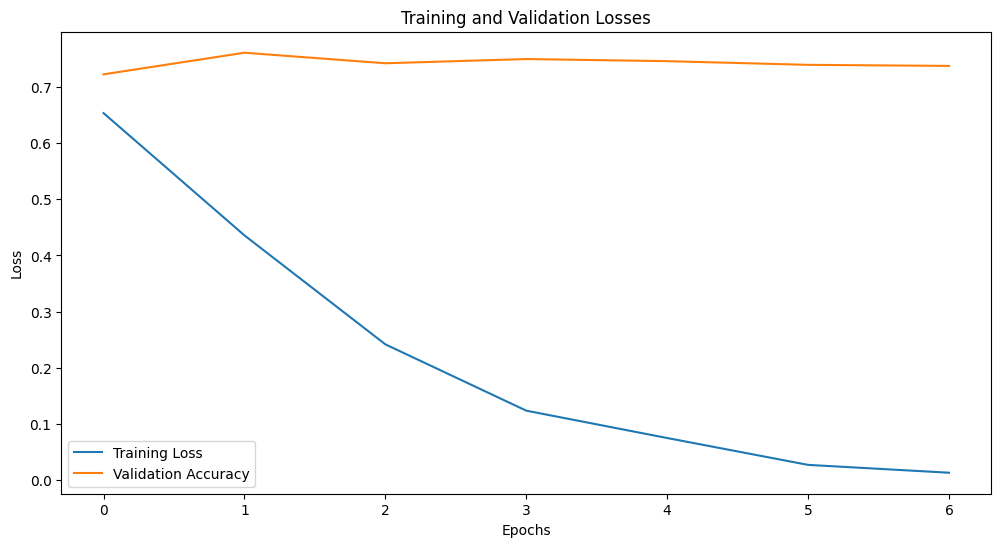

In [24]:
# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

train_losses, val_accuracies = [], []

In [25]:
# Training loop with validation and early stopping for biGRU
num_epochs = 30
patience = 5  # Early stopping patience
best_val_accuracy = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    bigru_model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        bigru_optimizer.zero_grad()
        outputs = bigru_model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bigru_model.parameters(), max_norm=1)  # Gradient clipping
        bigru_optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    bigru_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = bigru_model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduling
    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(bigru_model.state_dict(), 'best_bigru_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# Load the best model and evaluate on the test set for biGRU
bigru_model.load_state_dict(torch.load('best_bigru_model.pt'))
bigru_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = bigru_model(sequences)
        predicted = (outputs >= 0.5).long()
        correct += (predicted == labels.long()).sum().item()
        total += labels.size(0)
bigru_test_accuracy = correct / total
print(f'biGRU Test Accuracy: {bigru_test_accuracy:.4f}')

Epoch [1/30], Loss: 0.6313, Validation Accuracy: 0.7495
Epoch [2/30], Loss: 0.3805, Validation Accuracy: 0.7317
Epoch [3/30], Loss: 0.1991, Validation Accuracy: 0.7505
Epoch [4/30], Loss: 0.1044, Validation Accuracy: 0.7495
Epoch [5/30], Loss: 0.0468, Validation Accuracy: 0.7420
Epoch [6/30], Loss: 0.0238, Validation Accuracy: 0.7430
Epoch [7/30], Loss: 0.0157, Validation Accuracy: 0.7420
Epoch [8/30], Loss: 0.0105, Validation Accuracy: 0.7214
Early stopping!
biGRU Test Accuracy: 0.7824


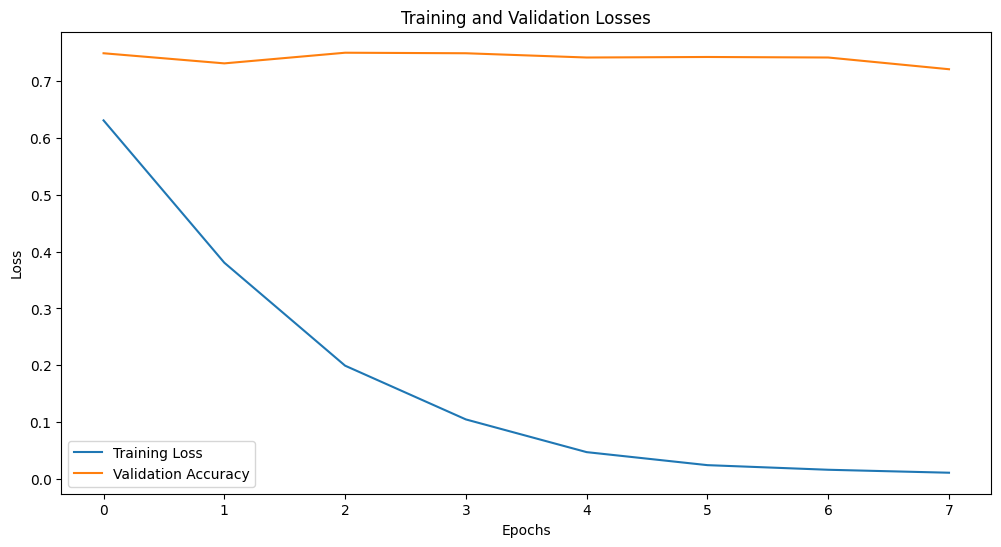

In [26]:
# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

train_losses, val_accuracies = [], []

In [27]:
# CNN Model
class SentimentCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentCNN, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x).permute(0, 2, 1)
        conv_out = self.conv1(embeds)
        pool_out = torch.max(conv_out, dim=-1)[0]
        out = self.dropout(pool_out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [28]:
# Instantiate the model
cnn_model = SentimentCNN(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(cnn_optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience
best_val_accuracy = 0
epochs_no_improve = 0

for epoch in range(num_epochs):
    cnn_model.train()
    running_loss = 0.0
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        cnn_optimizer.zero_grad()
        outputs = cnn_model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), max_norm=1)  # Gradient clipping
        cnn_optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    # Validation
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = cnn_model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduling
    scheduler.step(val_accuracy)

    # Check for improvement
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        # Save the best model
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

# Load the best model and evaluate on the test set
cnn_model.load_state_dict(torch.load('best_cnn_model.pt'))
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        outputs = cnn_model(sequences)
        predicted = (outputs >= 0.5).long()
        correct += (predicted == labels.long()).sum().item()
        total += labels.size(0)
cnn_test_accuracy = correct / total
print(f'CNN Test Accuracy: {cnn_test_accuracy:.4f}')

Epoch [1/30], Loss: 0.6587, Validation Accuracy: 0.7383
Epoch [2/30], Loss: 0.4292, Validation Accuracy: 0.7786
Epoch [3/30], Loss: 0.2048, Validation Accuracy: 0.7636
Epoch [4/30], Loss: 0.0761, Validation Accuracy: 0.7702
Epoch [5/30], Loss: 0.0297, Validation Accuracy: 0.7505
Epoch [6/30], Loss: 0.0137, Validation Accuracy: 0.7589
Epoch [7/30], Loss: 0.0070, Validation Accuracy: 0.7514
Early stopping!
CNN Test Accuracy: 0.7964


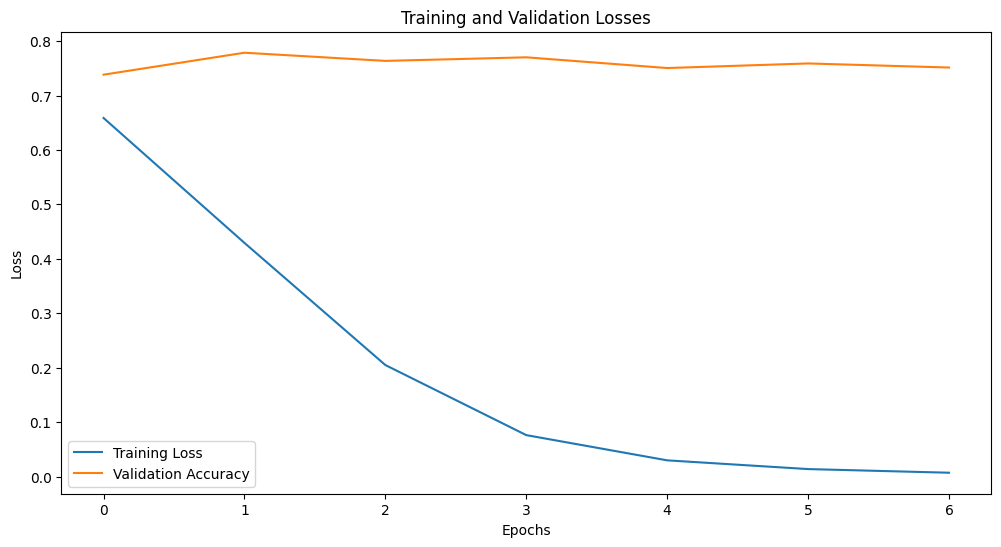

In [29]:
# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

train_losses, val_accuracies = [], []